In [94]:
#inclusions and imports
import numpy as np
import matplotlib.pyplot as plt

# Task 1
Q: Analytically provide a design for the quantum XOR oracle for this function and give explicitly
the 8 dimensional unitary matrix that implements it

A: On paper(attached)

# Task 2
Q: In this sub-question and the rest ignore the 3rd qubit. Analytically calculate the 4 dimensional
Reflection matrices that you need for the quantum design the quantum circuit for the Grover’s
algorithm that should be able to solve the problem with two call of the oracle function.

A: On paper(attached)

# Task 3
Q: Implement the circuit in python, where you use the matrices of the previous question and
provide a diagram of the fidelity of the final state to the solution as a number of applications of
the Grover’s Block. What do you observe? Why?

A: Grover's ALgorithm finds the solution after
$\frac{\pi}{4}\sqrt{N}$ steps. If we exceed this number of steps fidelity starts to decrease due to over-rotation of the of the searching vector

In [95]:
# init matrix generation functions

def calc_Hadamard_gate_n_qubits(n_qubits):
  # calculate Hadamard gate for every qubit of the circuit aka H^n
  H_1 = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
  H_n = H_1
  for i in range(n_qubits-1):
    H_n = np.kron(H_1, H_n)
  return H_n

def calc_input_state(n_qubits):
  # init the state vector of |0>^n
  dim = 2**n_qubits # actual matrices dimension
  input_state = np.zeros(dim)
  input_state[0] = 1 # ex. for n_qubits=2 input=(1,0,0,0) aka |00>

  return input_state

def calc_oracle(n_qubits, targets):
  # calculate the oracle. normally we only have a single target
  # for this usecase we input a structure of multiple targets to test Grovers behaviour
  dim = 2**n_qubits
  Uf = np.eye(dim)
  for target in targets:
    Uf[target, target] = -1 # (-1^f(x))

  return Uf

def calc_deffusion(n_qubits, input_state):
  # calculate the difussion matrix given as
  # D = H^n * (2|0...0><0...0 - I^n) * H^n

  # 1st choice
  # calculate Hadamard matrix H^n
  dim = 2**n_qubits # actual matrices dimension
  H_n = calc_Hadamard_gate_n_qubits(n_qubits)
  # calculate inermidiate matrix 2|0...0><0...0 - I^n
  temp_vec_ket = np.zeros(dim)
  temp_vec_ket[0] = 1
  temp_vec_bra = temp_vec_ket.T
  table = 2 * np.outer(temp_vec_ket, temp_vec_bra) - np.eye(dim)
  D = H_n @ table @ H_n

  # 2nd choice
  # For simplicity D is generalized as 2(H^n|input><input|H^n) - I^n
  # we are going to use this caclulate call grover on the orthogonality of a different basis
  temp_state = H_n @ input_state
  D = 2 * np.outer(temp_state, temp_state) - np.eye(dim)

  return D



In [96]:
# algorithmn and measurement and h-functions

def measurement_probabilities(vector):
  # calculate the probabilities of measurement of each state of a vector in superposition
  n_states = len(vector)
  probabilities = np.zeros(n_states)
  for i in range(n_states):
    probabilities[i] = np.abs(vector[i])**2

  return probabilities

def calc_fidelity(vector, target):
  # calculate the pfidelity of the target state of a vector in superposition

  # just targets probability
  #return np.abs(vector[target])**2

  # w/given probabilities
  prob = measurement_probabilities(vector)
  return prob[target]

def plot_fidelity_measurements(fidelity_measurements, iter):
  # plot the fidelity measurements to the number of iterations
  plt.plot(range(iter), fidelity_measurements)
  plt.xlabel('Iterations')
  plt.ylabel('Fidelity')
  plt.title('Fidelity vs Number f Iterations')
  plt.show()


def grovers_optimal_iterations(n_qubits):
  # calculate optimal number of iterations for Grover's algorithm
  return int((np.pi / 4) * np.sqrt(2**n_qubits))

def grovers_block(n_qubits, input_state, targets, Uf, D, iter):
  # executing Grover's algorithm block
  # the circuit is the following
  # input^n -> H^n -> BLOCK: [repeat:(Uf -> D)]
  # the number of iterations is considered to be an input(iter)
  # we can calc teh optimal number of iterations externally
  # for a proper visualization check paper(attached)
  H_n = calc_Hadamard_gate_n_qubits(n_qubits)
  state = H_n @ input_state
  fidelity_measurements = np.zeros((len(targets), iter))

  for i in range(iter):
    state = Uf @ state
    state = D @ state
    for j in range(len(targets)):
      fidelity_measurements[j, i] = calc_fidelity(state, targets[j])

  return state, fidelity_measurements

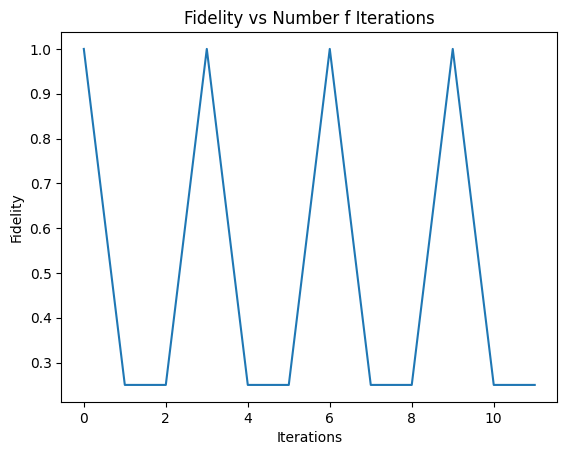

In [109]:
n_qubits = 2

input_state = calc_input_state(n_qubits)

# we choose the target state, here |11>=3
targets = [2]
#targets[0] = 3
Uf = calc_oracle(n_qubits, targets)
#print("Oracle matrix:")
#print(Uf)
D = calc_deffusion(n_qubits, input_state)
#print("Deffusion matrix:")
#print(D)

iterations = 12

final_state, fidelity_measurements = grovers_block(n_qubits, input_state, targets, Uf, D, iterations)

#print(f"Final state: {final_state}")
#print(f"Fidelity measurements: {fidelity_measurements}")
for i in range(len(targets)):
  plot_fidelity_measurements(fidelity_measurements[i], iterations)

# Task 4
Q: Modify your Reflection operator and test your circuit for an oracle that marks two solutions
instead of one, as
𝒇(𝟎) = 𝟎, 𝒇(𝟏) = 𝟎, 𝒇(𝟐) = 𝟏, 𝒇(𝟑) = 𝟏
Does the repetition of the algorithm provides the solution (a supersposition of two state
solutions)? Justify your answer.

A: Grover moves at every step at $\theta = 2\arcsin(\frac{1}{\sqrt{N}})$. When we have multiple posible solutions(let M), the steps are given by $\theta = 2\arcsin(\frac{\sqrt{M}}{\sqrt{N}})$. Thus, in 4 dimensions with 2 solutions we will start form $\frac{\pi}{4}$ and move with a step of $\frac{\pi}{2}$ continuesly overshooting our target.
[source](https://quantumcomputing.stackexchange.com/questions/33468/does-grover-work-for-more-than-n-2-solutions)

Weird Idea: In a lab example where we know the two states we are looking for we can execute Grover's Algorithm given as input the superposition of all eigenvectors of the basis that our targeted superposition is one of the eigenvectors.

Example: If we are looking for 𝒇(𝟎) = 𝟏, 𝒇(𝟏) = 𝟎, 𝒇(𝟐) = 𝟎, 𝒇(𝟑) = 𝟏 we can run the algorithm on the Bell basis. We will initialize our input state as the superposition of all Bell states and then modify our oracle and difussion matrices to take this as input too. Our target vector remains ths perfect superposition of 0 and 3 aka B00. The algorithm returns the deisred Bell state after one execution.

In real life we do not know the targeted vector, therefore we are obligated to chekc all the N-1 bases containing all the different combinations of two states of the Normal Basis.

For 2 qubits and 2 solutions

Base 1: $\{ \frac{|00\rangle \pm |11\rangle}{\sqrt{2}}, \; \frac{|01\rangle \pm |10\rangle}{\sqrt{2}} \}$

Base 2: $\{ \frac{|00\rangle \pm |01\rangle}{\sqrt{2}}, \; \frac{|10\rangle \pm |11\rangle}{\sqrt{2}} \}$

Base 3: $\{ \frac{|00\rangle \pm |10\rangle}{\sqrt{2}}, \; \frac{|01\rangle \pm |11\rangle}{\sqrt{2}} \}$

Fun fact: for 2 qubits this performes like the normal search ($N-1$ steps) as it requires three different basis 1 time runs thus $(N-1) \frac{\pi}{4} \sqrt{N}$.

For larger node counts of course $O((N-1) \frac{\pi}{4} \sqrt{N})$ is worse than $(O(N))$

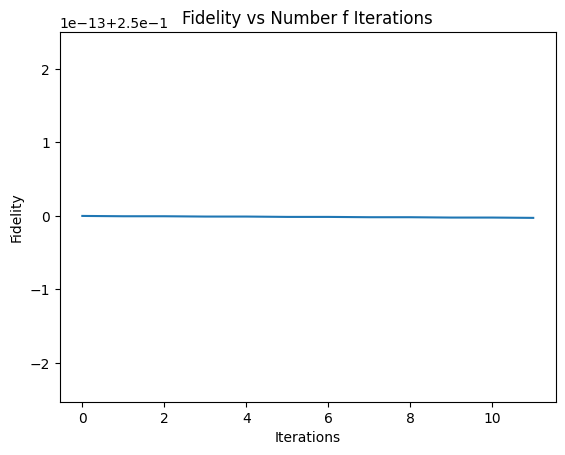

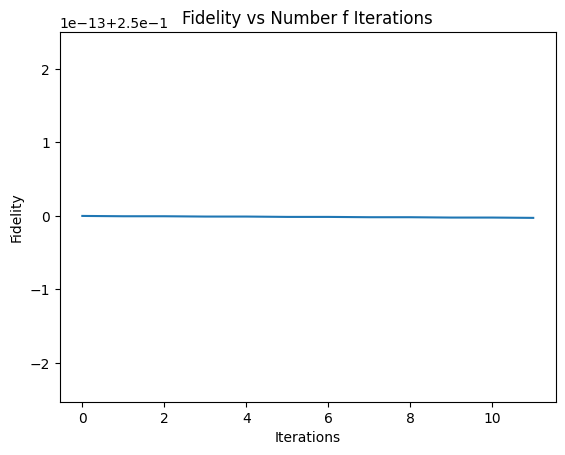

In [98]:
# First try: just choose 2 target states and run or existing circuit
# we choose the target states, here |11>=3 AND |10>
targets = [3, 2]
Uf = calc_oracle(n_qubits, targets)
#print("Oracle matrix:")
#print(Uf)
D = calc_deffusion(n_qubits, input_state)
#print("Deffusion matrix:")
#print(D)

iterations = 12

final_state, fidelity_measurements = grovers_block(n_qubits, input_state, targets, Uf, D, iterations)

for i in range(len(targets)):
  plot_fidelity_measurements(fidelity_measurements[i], iterations)
  #print(f"fidelity over iter for finding {targets[1]}: {fidelity_measurements[i]}")

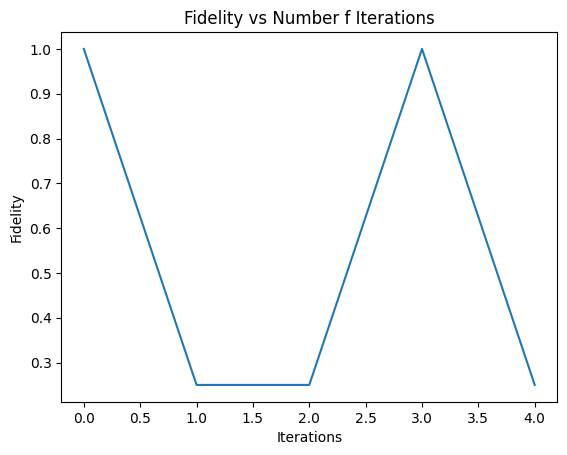

In [136]:
# Second try: execute Grover in the basis where targeted superposition is one of the eigenvector
# we choose the target states, here |00>=0 AND |11>=1
input_state = np.array([1, 1, 0, 0]) / np.sqrt(2) # superposition of all the Bell states
target_vector = np.array([1, 0, 0, 1]) / np.sqrt(2) #|00> and |11> our target
targets = [0, 3] # so the superposition of 00> and 11> aka B00
iter = 5

dim = 2**n_qubits
proj_target = np.outer(target_vector, target_vector)
Uf = np.eye(dim) - 2 * proj_target

D = 2 * np.outer(input_state, input_state) - np.eye(dim)

fidelity_measurements = np.zeros(iter)
state = input_state

for i in range(iter):
  state = Uf @ state
  state = D @ state
  fidelity = np.abs(np.dot(target_vector, state))**2
  fidelity_measurements[i] = fidelity

plot_fidelity_measurements(fidelity_measurements, iter)


# Task 5
Q: Implement the last question with a 3 qubit circuit. In other words implement
Grover’s algorithm for a function 𝑓: {0,1}3 → {0,1} with 2 solutions --that you choose as you
like.

A: In 8 dimensions, as m/N < 1/2, with m teh number of solutions the step is small enough to apporach the solutions correctly, see fidelity maximizing(at 0.5 as 0.5+0.5=1) every some steps

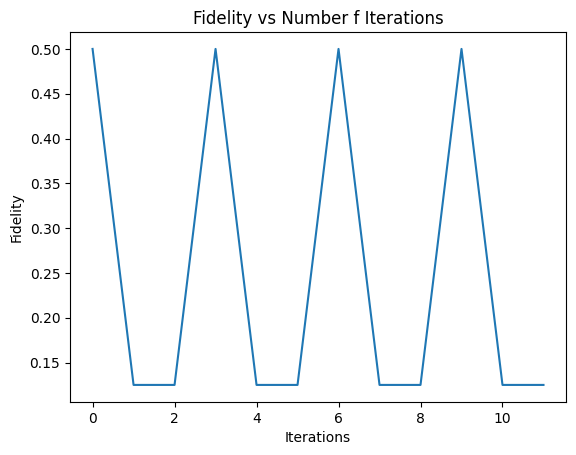

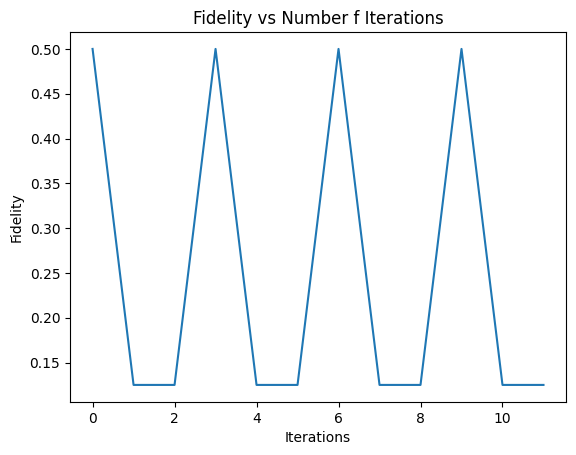

In [106]:
n_qubits = 3

input_state = calc_input_state(n_qubits)

# we choose the target states, here |11>=3 AND |10>
targets = [3, 2]
Uf = calc_oracle(n_qubits, targets)
#print("Oracle matrix:")
#print(Uf)
D = calc_deffusion(n_qubits, input_state)
#print("Deffusion matrix:")
#print(D)

iterations = 12

final_state, fidelity_measurements = grovers_block(n_qubits, input_state, targets, Uf, D, iterations)

for i in range(len(targets)):
  plot_fidelity_measurements(fidelity_measurements[i], iterations)
  #print(f"fidelity over iter for finding {targets[1]}: {fidelity_measurements[i]}")